<a href="https://colab.research.google.com/github/soumyanildey/Faster-R-CNN-ResNet50-v2/blob/main/Cat_Dog_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [2]:
!pip install datasets
from datasets import load_dataset

ds = load_dataset("microsoft/cats_vs_dogs")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

README.md:   0%|          | 0.00/8.16k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

In [4]:
from datasets import DatasetDict

# Assume `dataset` is your original DatasetDict with a 'train' split
# Split 20% of training data into validation
train_val = ds['train'].train_test_split(test_size=0.2, seed=42)

# Create a new DatasetDict with train and validation splits
ds = DatasetDict({
    'train': train_val['train'],
    'val': train_val['test']
})


In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 18728
    })
    val: Dataset({
        features: ['image', 'labels'],
        num_rows: 4682
    })
})

In [6]:
from PIL import Image
import torch



def transform(example):
    images = example['image']
    labels = example['labels']

    # Ensure all images are PIL RGB
    processed_images = []
    for img in images:
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img).convert("RGB")
        else:
            img = img.convert("RGB")
        processed_images.append(img)

    # Use the processor (batch of PIL images)
    inputs = processor(processed_images, return_tensors='pt', padding=True)

    return {
        'pixel_values': inputs['pixel_values'],
        'labels': torch.tensor(labels)
    }


def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


In [7]:
ds = ds.with_transform(transform)


In [8]:
labels = ds['train'].features['labels'].names
model = AutoModelForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
!pip install evaluate
import numpy as np
from evaluate import load

metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.2 MB/s eta 0:00:00


In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  eval_strategy="epoch",
  num_train_epochs=5,
  fp16=True,
  logging_steps=10,
  learning_rate=1e-4,
)


In [11]:
from transformers import Trainer,default_data_collator

# Create a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=ds["train"],
    eval_dataset=ds["val"],
)


In [12]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: soumyanildey (soumyanildey-gnit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.033200,0.036131,0.988894
2,0.033600,0.039173,0.989534
3,0.000200,0.041385,0.992738
4,0.000100,0.037286,0.992311
5,0.000000,0.036832,0.992738


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/usr/local/lib/p

TrainOutput(global_step=5855, training_loss=0.01594695966407644, metrics={'train_runtime': 1640.3771, 'train_samples_per_second': 57.084, 'train_steps_per_second': 3.569, 'total_flos': 7.256349907510395e+18, 'train_loss': 0.01594695966407644, 'epoch': 5.0})

Predicted class index: 0
Predicted class label: cat


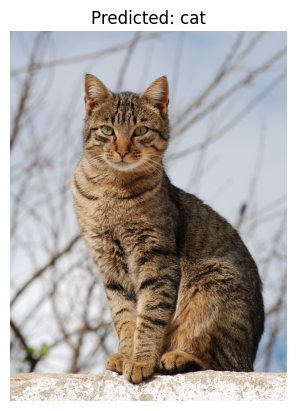

In [28]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Assuming processor and model are already defined and loaded

# Load the image
image = Image.open("/content/Cat_November_2010-1a.jpg")

# Preprocess the image and send it to the GPU
inputs = processor(images=image, return_tensors="pt").to("cuda")

# Get predictions without tracking gradients
with torch.no_grad():
    outputs = model(**inputs)

# Extract the logits and predicted class index
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

# Print the predicted class label
print("Predicted class index:", predicted_class_idx)
if predicted_class_idx == 0:
    print("Predicted class label: cat")
else:
    print("Predicted class label: dog")

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide axis for a cleaner look
plt.title(f"Predicted: {'cat' if predicted_class_idx == 0 else 'dog'}")
plt.show()


Predicted class index: 1
Predicted class label: dog


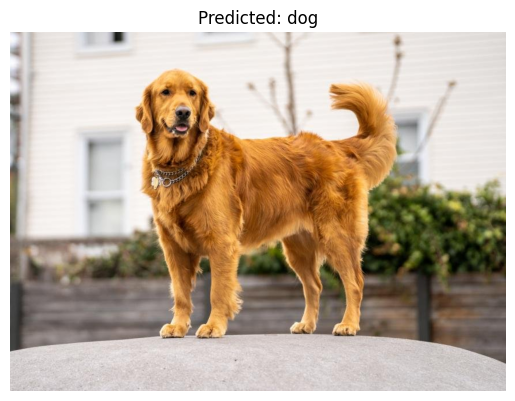

In [29]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Assuming processor and model are already defined and loaded

# Load the image
image = Image.open("/content/Golden+Retrievers+dans+pet+care.jpeg")

# Preprocess the image and send it to the GPU
inputs = processor(images=image, return_tensors="pt").to("cuda")

# Get predictions without tracking gradients
with torch.no_grad():
    outputs = model(**inputs)

# Extract the logits and predicted class index
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

# Print the predicted class label
print("Predicted class index:", predicted_class_idx)
if predicted_class_idx == 0:
    print("Predicted class label: cat")
else:
    print("Predicted class label: dog")

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide axis for a cleaner look
plt.title(f"Predicted: {'cat' if predicted_class_idx == 0 else 'dog'}")
plt.show()


Predicted class index: 0
Predicted class label: cat


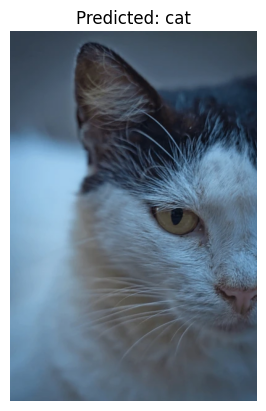

In [30]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Assuming processor and model are already defined and loaded

# Load the image
image = Image.open("/content/black-white-cat-half-face-600nw-2480906999.webp")

# Preprocess the image and send it to the GPU
inputs = processor(images=image, return_tensors="pt").to("cuda")

# Get predictions without tracking gradients
with torch.no_grad():
    outputs = model(**inputs)

# Extract the logits and predicted class index
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

# Print the predicted class label
print("Predicted class index:", predicted_class_idx)
if predicted_class_idx == 0:
    print("Predicted class label: cat")
else:
    print("Predicted class label: dog")

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide axis for a cleaner look
plt.title(f"Predicted: {'cat' if predicted_class_idx == 0 else 'dog'}")
plt.show()


Predicted class index: 1
Predicted class label: dog


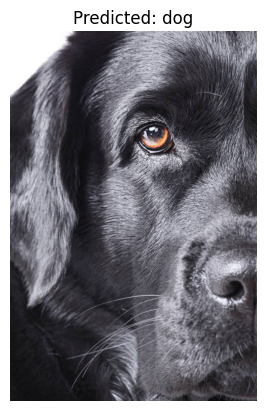

In [31]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Assuming processor and model are already defined and loaded

# Load the image
image = Image.open("/content/istockphoto-2051556300-612x612.jpg")

# Preprocess the image and send it to the GPU
inputs = processor(images=image, return_tensors="pt").to("cuda")

# Get predictions without tracking gradients
with torch.no_grad():
    outputs = model(**inputs)

# Extract the logits and predicted class index
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

# Print the predicted class label
print("Predicted class index:", predicted_class_idx)
if predicted_class_idx == 0:
    print("Predicted class label: cat")
else:
    print("Predicted class label: dog")

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide axis for a cleaner look
plt.title(f"Predicted: {'cat' if predicted_class_idx == 0 else 'dog'}")
plt.show()
